In [ ]:
# ==========================
# YOLO + ResNet50 Pipeline (Windows-friendly, ready-to-run)
# ==========================
import os
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm   # ✅ เพิ่มมาแล้ว

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

from PIL import Image
from ultralytics import YOLO

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split  # ✅ เพิ่มมาแล้ว

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.1 MB/s eta 0:00:00


In [ ]:
# ==========================
# 0️⃣ Set Seed
# ==========================
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
data_dir = r"/content/drive/MyDrive/training_setcat1/AugmentedDataset"  # ปรับตามเครื่องคุณ
yolo_weights = "best.pt"           # ปรับตามไฟล์ของคุณ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# ==========================
# 1️⃣ Dataset Check
# ==========================
def check_dataset(data_dir, classes=None):
    img_ext = [".jpg", ".jpeg", ".png", ".bmp"]
    missing_classes = []
    total_images = 0
    if classes is None:
        classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    for cls in classes:
        folder = os.path.join(data_dir, cls)
        if not os.path.exists(folder):
            missing_classes.append(cls)
            continue
        files = [f for f in os.listdir(folder) if any(f.lower().endswith(ext) for ext in img_ext)]
        if len(files) == 0:
            missing_classes.append(cls)
        else:
            print(f"✅ {cls}: พบ {len(files)} ไฟล์")
            total_images += len(files)
    if missing_classes:
        print("Class ต่อไปนี้ไม่มีภาพหรือโฟลเดอร์หาย:", missing_classes)
    else:
        print("Dataset ครบทุก class แล้ว")
    print(f"รวมทั้งหมด {total_images} ไฟล์\n")
    return total_images, missing_classes

total_images, missing = check_dataset(data_dir)
if total_images == 0:
    raise RuntimeError("❌ ไม่พบไฟล์รูปภาพใน dataset เลย!")

✅ T2: พบ 372 ไฟล์
✅ T3: พบ 365 ไฟล์
✅ T1: พบ 531 ไฟล์
✅ T4: พบ 342 ไฟล์
Dataset ครบทุก class แล้ว
รวมทั้งหมด 1610 ไฟล์



In [ ]:
# ==========================
# 2️⃣ Transform / Augmentation
# ==========================
transform_train = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [ ]:
# ==========================
# 3️⃣ Load Dataset & Split
# ==========================
full_dataset = datasets.ImageFolder(root=data_dir, transform=None)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['T1', 'T2', 'T3', 'T4']


In [ ]:
# ==========================
# 4️⃣ Count per class
# ==========================
paths = [p for p, _ in full_dataset.samples]
labels = [l for _, l in full_dataset.samples]

train_idx, test_idx = train_test_split(
    list(range(len(paths))),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_dataset_base = Subset(full_dataset, train_idx)
test_dataset_base = Subset(full_dataset, test_idx)

def count_per_class(subset, name="Dataset"):
    targets = [full_dataset.samples[i][1] for i in subset.indices]
    counter = Counter(targets)
    print(f"\n{name} class distribution:")
    for cls_idx, cls_name in enumerate(full_dataset.classes):
        print(f"{cls_name}: {counter.get(cls_idx, 0)}")

count_per_class(train_dataset_base, "Train")
count_per_class(test_dataset_base, "Test")

# ==========================


Train class distribution:
T1: 425
T2: 297
T3: 292
T4: 274

Test class distribution:
T1: 106
T2: 75
T3: 73
T4: 68


In [ ]:
# ==========================
# 5️⃣ Load YOLO model
# ==========================
yolo_model = YOLO("/content/drive/MyDrive/best.pt")  # กำหนด device ถ้าต้องการ: YOLO(yolo_weights, device='0')
# จะไม่เรียก predict บ่อย ๆ — เราจะรัน detection ล่วงหน้าและ cache ผล

In [ ]:
# ==========================
# 6️⃣ YOLO Crop Function
# ==========================
yolo_cache = {}
all_paths = [full_dataset.samples[i][0] for i in range(len(full_dataset.samples))]

print("Running YOLO detection on all images (caching) ...")
# ultralytics can accept a list of paths; batch it to avoid OOM
batch_size = 64
for i in tqdm (range(0, len(all_paths), batch_size)):
    batch_paths = all_paths[i:i+batch_size]
    # run prediction for this batch
    results = yolo_model.predict(source=batch_paths, verbose=False)  # returns list aligned with batch_paths
    for p, res in zip(batch_paths, results):
        if hasattr(res, "boxes") and len(res.boxes) > 0:
            # take first box (you can choose best by confidence if you want)
            box = res.boxes.xyxy[0].cpu().numpy()
            x1, y1, x2, y2 = map(int, box)
            # ignore too-small boxes
            if (x2 - x1) < 20 or (y2 - y1) < 20:
                yolo_cache[p] = None
            else:
                # clamp to image bounds
                try:
                    with Image.open(p) as tmp:
                        w, h = tmp.size
                    x1 = max(0, min(x1, w-1))
                    x2 = max(0, min(x2, w-1))
                    y1 = max(0, min(y1, h-1))
                    y2 = max(0, min(y2, h-1))
                except:
                    pass
                yolo_cache[p] = (x1, y1, x2, y2)
        else:
            yolo_cache[p] = None

Running YOLO detection on all images (caching) ...


100%|██████████| 26/26 [10:22<00:00, 23.94s/it]


In [ ]:
# ==========================
# 7️⃣ Custom Dataset with YOLO Crop
# ==========================
class YOLOCachedCroppedDataset(torch.utils.data.Dataset):
    def __init__(self, subset: Subset, cache: dict, transform=None, transform_test=False):
        self.subset = subset
        self.cache = cache
        self.transform = transform
        self.transform_test = transform_test  # unused here but kept for clarity

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        path, label = self.subset.dataset.samples[self.subset.indices[idx]]
        try:
            image = Image.open(path).convert("RGB")
        except Exception as e:
            # fallback black image
            image = Image.new("RGB", (224,224), (0,0,0))
        box = self.cache.get(path, None)
        if box is not None:
            x1,y1,x2,y2 = box
            try:
                image = image.crop((x1,y1,x2,y2))
            except:
                pass
        # apply transform (should be resize->tensor->normalize)
        if self.transform:
            image = self.transform(image)
        return image, label

# instantiate datasets
train_dataset = YOLOCachedCroppedDataset(train_dataset_base, yolo_cache, transform=transform_train)
test_dataset = YOLOCachedCroppedDataset(test_dataset_base, yolo_cache, transform=transform_test)
print(f"\nFinal Train dataset size: {len(train_dataset)}")
print(f"Final Test dataset size: {len(test_dataset)}")



Final Train dataset size: 1288
Final Test dataset size: 322


In [ ]:
# -------------------------
# 8. DataLoaders (Windows note: use __main__ guard when num_workers>0)
# -------------------------
batch_size = 16
num_workers = 4  # on Windows must be used inside if __name__ == "__main__"
pin_memory = True if torch.cuda.is_available() else False


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# ==========================
# โหลด Vision Transformer (ViT-B_16)
# ==========================
vit = models.vit_b_16(pretrained=True)

# แก้ Fully Connected Layer สุดท้าย ให้ตรงกับจำนวน class
num_ftrs = vit.heads.head.in_features
vit.heads.head = nn.Linear(num_ftrs, num_classes)

# ส่งไปยัง device
vit = vit.to(device)

# Loss function และ Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=1e-4, weight_decay=1e-5)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 177MB/s]


In [ ]:
# ==========================
# 9️⃣ Training Loop (ResNet101)
# ==========================
def train_and_eval():
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=pin_memory)

    print("Train dataset size:", len(train_dataset))
    print("Test dataset size:", len(test_dataset))

    best_vit_wts = copy.deepcopy(vit.state_dict())
    best_acc = 0.0

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    epochs = 30
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-"*20)
        # --- Train ---
        vit.train()
        running_loss = 0.0
        running_corrects = 0
        for images, labels in tqdm(train_loader, desc="Train"):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = vit(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # --- Eval ---
        vit.eval()
        test_loss = 0.0
        test_corrects = 0
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Eval"):
                images = images.to(device)
                labels = labels.to(device)
                outputs = vit(images)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                test_corrects += torch.sum(preds == labels.data).item()

        test_loss = test_loss / len(test_dataset)
        test_acc = test_corrects / len(test_dataset)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Test  Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

        # save best
        if test_acc > best_acc:
            best_acc = test_acc
            best_vit_wts = copy.deepcopy(vit.state_dict())
            torch.save(best_vit_wts, "best_vit.pt")
            print("✅ Model improved, saved best_vit.pt")

    # load best and return metrics
    vit.load_state_dict(best_vit_wts)
    return train_losses, test_losses, train_accs, test_accs, train_loader, test_loader


if __name__ == "__main__":
    train_losses, test_losses, train_accs, test_accs, train_loader, test_loader = train_and_eval()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train dataset size: 1288
Test dataset size: 322

Epoch 1/30
--------------------


Eval: 100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


Train Loss: 1.2047 Acc: 0.4627
Test  Loss: 1.0390 Acc: 0.5590
✅ Model improved, saved best_vit.pt

Epoch 2/30
--------------------


Eval: 100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


Train Loss: 0.8887 Acc: 0.6398
Test  Loss: 0.7245 Acc: 0.7081
✅ Model improved, saved best_vit.pt

Epoch 3/30
--------------------


Eval: 100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Train Loss: 0.6217 Acc: 0.7531
Test  Loss: 0.4917 Acc: 0.8385
✅ Model improved, saved best_vit.pt

Epoch 4/30
--------------------


Eval: 100%|██████████| 21/21 [00:04<00:00,  4.69it/s]


Train Loss: 0.4467 Acc: 0.8377
Test  Loss: 0.3432 Acc: 0.8789
✅ Model improved, saved best_vit.pt

Epoch 5/30
--------------------


Train:  10%|▉         | 8/81 [00:05<00:44,  1.63it/s]

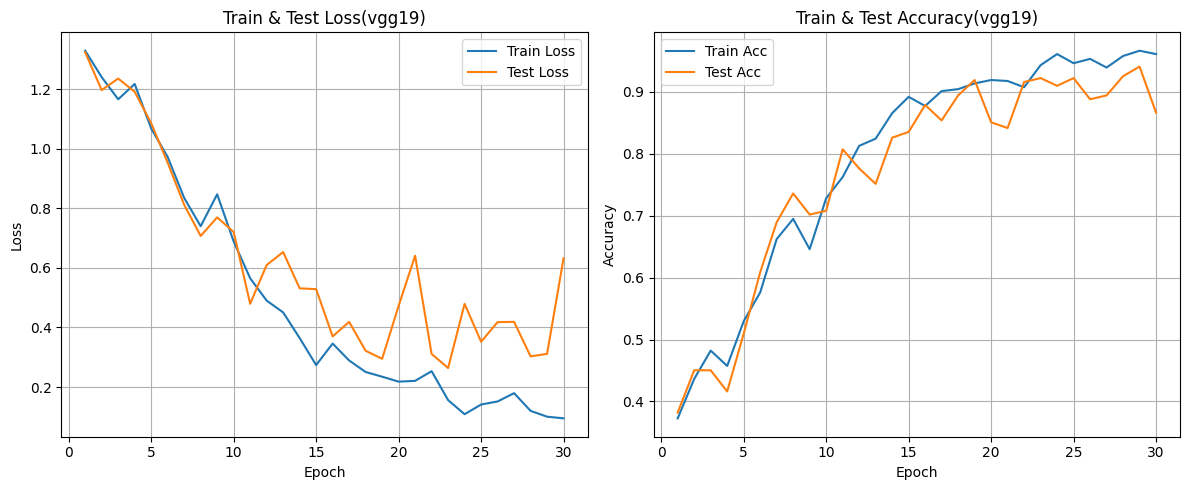

In [ ]:
# ==========================
# 🔟 Plot Loss & Accuracy
# ==========================
epochs_range = range(1,len(train_losses)+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses,label='Train Loss')
plt.plot(epochs_range, test_losses,label='Test Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Train & Test Loss(vgg19)')
plt.legend(); plt.grid(True)
plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs,label='Train Acc')
plt.plot(epochs_range, test_accs,label='Test Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Train & Test Accuracy(vgg19)')
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


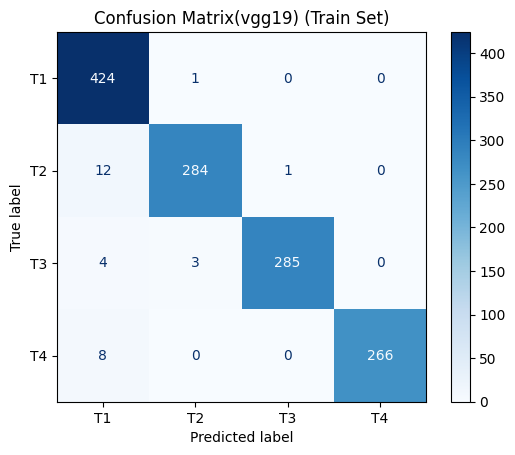

=== Evaluation Metrics(vgg19) (Train Set) ===
Accuracy: 0.9775
T1 → Precision: 0.9464, Recall: 0.9976, F1-score: 0.9714
T2 → Precision: 0.9861, Recall: 0.9562, F1-score: 0.9709
T3 → Precision: 0.9965, Recall: 0.9760, F1-score: 0.9862
T4 → Precision: 1.0000, Recall: 0.9708, F1-score: 0.9852

=== Classification Report(vgg19) ===
              precision    recall  f1-score   support

          T1       0.95      1.00      0.97       425
          T2       0.99      0.96      0.97       297
          T3       1.00      0.98      0.99       292
          T4       1.00      0.97      0.99       274

    accuracy                           0.98      1288
   macro avg       0.98      0.98      0.98      1288
weighted avg       0.98      0.98      0.98      1288



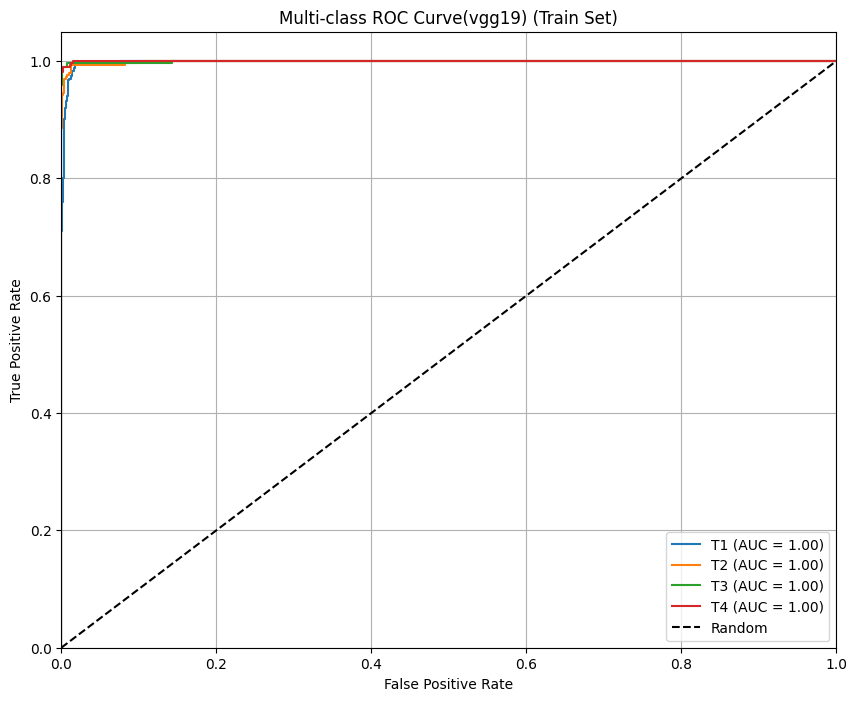

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


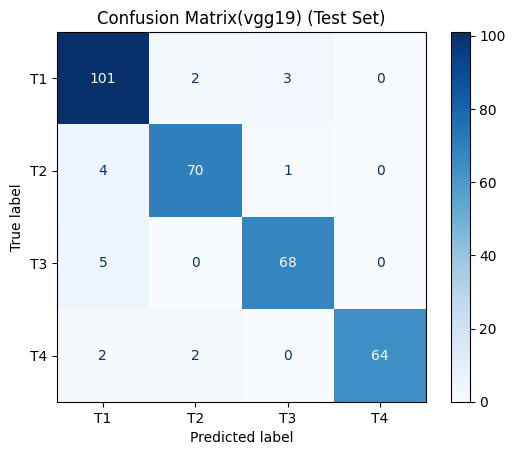

=== Evaluation Metrics(vgg19) (Test Set) ===
Accuracy: 0.9410
T1 → Precision: 0.9018, Recall: 0.9528, F1-score: 0.9266
T2 → Precision: 0.9459, Recall: 0.9333, F1-score: 0.9396
T3 → Precision: 0.9444, Recall: 0.9315, F1-score: 0.9379
T4 → Precision: 1.0000, Recall: 0.9412, F1-score: 0.9697

=== Classification Report(vgg19) ===
              precision    recall  f1-score   support

          T1       0.90      0.95      0.93       106
          T2       0.95      0.93      0.94        75
          T3       0.94      0.93      0.94        73
          T4       1.00      0.94      0.97        68

    accuracy                           0.94       322
   macro avg       0.95      0.94      0.94       322
weighted avg       0.94      0.94      0.94       322



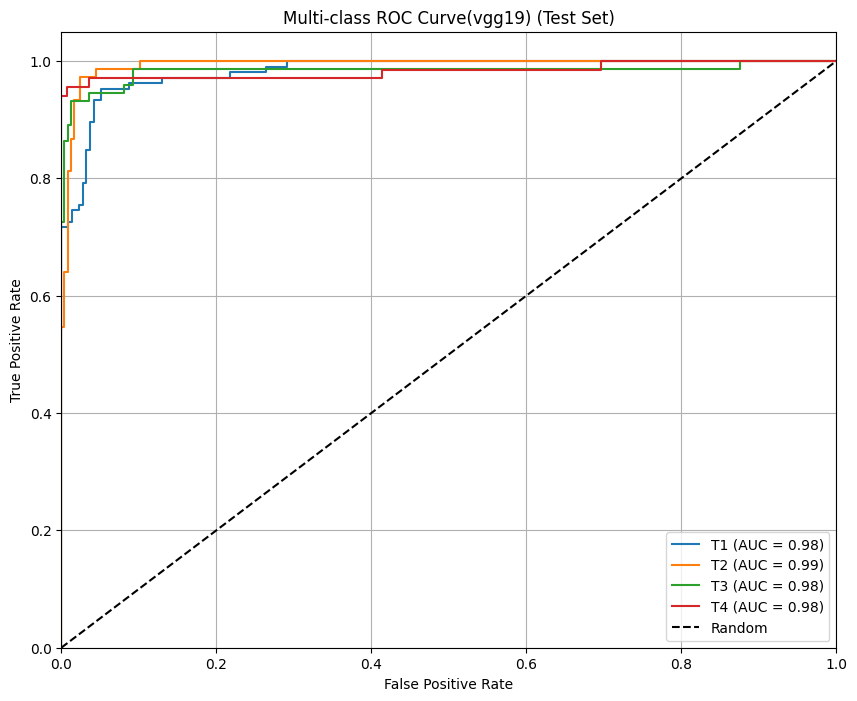

In [ ]:
# ==========================
#  🔟 Evaluation (Train + Test)
# ==========================

def evaluate_model(model, dataloader, dataset_name="Test"):
    model.eval()
    y_true, y_pred = [], []
    y_score = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(probs.cpu().numpy())

    class_names = full_dataset.classes
    y_true_labels = [class_names[i] for i in y_true]
    y_pred_labels = [class_names[i] for i in y_pred]
    y_score = np.array(y_score)

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix(vgg19) ({dataset_name} Set)")
    plt.show()

    # --- Metrics ---
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    precision = precision_score(y_true_labels, y_pred_labels, labels=class_names, average=None, zero_division=0)
    recall = recall_score(y_true_labels, y_pred_labels, labels=class_names, average=None, zero_division=0)
    f1 = f1_score(y_true_labels, y_pred_labels, labels=class_names, average=None, zero_division=0)

    print(f"=== Evaluation Metrics(vgg19) ({dataset_name} Set) ===")
    print(f"Accuracy: {accuracy:.4f}")
    for i, cls in enumerate(class_names):
        print(f"{cls} → Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-score: {f1[i]:.4f}")

    print("\n=== Classification Report(vgg19) ===")
    print(classification_report(y_true_labels, y_pred_labels, labels=class_names, zero_division=0))

    # --- Multi-class ROC Curve ---
    y_true_onehot = label_binarize(y_true, classes=list(range(len(class_names))))
    plt.figure(figsize=(10,8))
    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.2f})')

    plt.plot([0,1],[0,1],'k--', label='Random')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-class ROC Curve(vgg19) ({dataset_name} Set)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


# ==========================
# Run Evaluation on Train & Test
# ==========================
evaluate_model(vgg19, train_loader, dataset_name="Train")
evaluate_model(vgg19, test_loader, dataset_name="Test")


In [ ]:
torch.save(vgg19.state_dict(), r"/content/best_vgg19.pth")



In [ ]:


# แก้ path ให้ตรงกับที่ไฟล์เก็บไว้
best_weights_path = "/content/best_vgg19.pth"

vgg19.load_state_dict(torch.load(best_weights_path, map_location="cpu"))
vgg19.eval()

# บันทึกโมเดลเต็มใน Drive ด้วย
web_model_path = "/content/vgg19_web_model.pt"
torch.save(vgg19, web_model_path)
print(f"✅ โมเดลบันทึกเรียบร้อยสำหรับเว็บแอพที่: {web_model_path}")


✅ โมเดลบันทึกเรียบร้อยสำหรับเว็บแอพที่: /content/vgg19_web_model.pt


In [ ]:
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2
import numpy as np

# ===========================
# 1️⃣ โหลด YOLO segmentation model
# ===========================
yolo_model = YOLO("best.pt")  # สำหรับตรวจจับก้อนเนื้อ

# ===========================
# 2️⃣ โหลด classification model (ResNet50) แบบ state_dict
# ===========================
resnet50_path = "/content/resnet50_web_model2.pt"   # ไฟล์ state_dict
class_names = ["T1","T2","T3","T4"]

# สร้างโครง ResNet50 ใหม่
resnet50 = models.resnet50(pretrained=False)
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, len(class_names))

# โหลด weights
resnet50.load_state_dict(torch.load(resnet50_path, map_location="cpu"))
resnet50.eval()

# ===========================
# 3️⃣ Transform สำหรับ ResNet50
# ===========================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ===========================
# 4️⃣ ฟังก์ชัน detect + classify + draw box + label + logits/probs debug
# ===========================
def detect_and_predict_fixed(image_path):
    # โหลดภาพ
    image = np.array(Image.open(image_path).convert("RGB"))
    orig_image = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2BGR)

    # YOLO detect
    results = yolo_model(image)
    boxes = results[0].boxes.xyxy.cpu().numpy()

    if len(boxes) == 0:
        print("❌ ไม่พบวัตถุจาก YOLO")
        return []

    predicted_labels = []

    for idx, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        roi = image[y1:y2, x1:x2]

        if roi.size == 0:
            continue

        # Resize ROI ให้ตรงกับ ResNet50
        roi_pil = Image.fromarray(roi).resize((224, 224))
        roi_tensor = transform(roi_pil).unsqueeze(0)

        # Classification
        with torch.no_grad():
            outputs = resnet50(roi_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            print(f"ROI {idx+1} probs:", probs.cpu().numpy())
            _, pred = torch.max(outputs, 1)
            predicted_class = class_names[pred.item()]
            predicted_labels.append(predicted_class)

        # วาดกรอบและ label
        cv2.rectangle(orig_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(orig_image, predicted_class, (x1, max(0, y1 - 10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    # แสดงภาพ
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    return predicted_labels

# ===========================
# 5️⃣ ทดสอบภาพตัวอย่าง
# ===========================
test_image = "/content/drive/MyDrive/training_setcat1/AugmentedDataset/T4/aug_0_1139.jpg"
detect_and_predict_fixed(test_image)


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torchvision.models.resnet.ResNet was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torchvision.models.resnet.ResNet])` or the `torch.serialization.safe_globals([torchvision.models.resnet.ResNet])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.